In [1]:
# Download Repository
! git clone https://github.com/matterport/Mask_RCNN.git

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 116.77 MiB | 2.75 MiB/s, done.
Resolving deltas: 100% (564/564), done.


In [2]:
! pip install tensorflow==1.14.0
! pip install keras==2.1.3

     |████████████████████████████████| 109.2MB 38kB/s 
     |████████████████████████████████| 491kB 47.1MB/s 
     |████████████████████████████████| 51kB 8.0MB/s 
     |████████████████████████████████| 3.2MB 52.4MB/s 
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: tensorflow 2.3.0
    Uninstalling tensorflow-2.3.0:
      Successfully uninstalled tensorflow-2.3.0
     |████████████████████████████████| 327kB 8.6MB/s 
ERROR: textgenrnn 1.4.1 has requirement keras>=2.1.5, but you'll have keras 2.1.3 which is incompatible.
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [5]:
import os
import sys
import numpy as np
import random
import cv2
import matplotlib.pyplot as plt


In [6]:
# Root directory of the project
# When drive is mounted, prepend content 
ROOT_DIR = os.path.join('')
sys.path.append(ROOT_DIR)
# append mounted google drive to path for using mrcnn
GDRIVE_DATASET_PATH  = ''
sys.path.append(GDRIVE_DATASET_PATH)

In [8]:
from mrcnn.config import Config
from mrcnn.model import log
from mrcnn import visualize
import mrcnn.model as modellib
import tensorflow as tf
# silent tf verbose
tf.get_logger().setLevel('INFO')

In [9]:
from loader import InferenceConfig, FarmDamDataset
import mrcnn.model as modellib

In [10]:
inference_config = InferenceConfig()
inference_config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [18]:
# Global variables

# path/gdrive path where the model is saved
MODEL_PERS_DIR = os.path.join(GDRIVE_DATASET_PATH, '')
# saved model path
SAVED_MODEL_PATH = os.path.join(MODEL_PERS_DIR,'mask_rcnn_farm_dam_0005.h5')

# training part
DATASET_PATH = os.path.join(os.getcwd(), GDRIVE_DATASET_PATH,'dataset')

In [19]:
# validation images dir
dataset_train = FarmDamDataset()
dataset_train.load_dam(DATASET_PATH, "train")
dataset_train.prepare()

# validation images dir
dataset_val = FarmDamDataset()
dataset_val.load_dam(DATASET_PATH, "val")
dataset_val.prepare()

In [21]:
def load_transfered_learned_model(model_per_dir, model_saved_path, config):
  # Create model in training mode
  model = modellib.MaskRCNN(mode="train", config=config, model_dir=model_per_dir)
  # Load weights trained on MS COCO, but skip layers that
  # are different due to the different number of classes
  print("Loading weights from ", model_saved_path)
  model.load_weights(model_saved_path, by_name=True)
  return model

In [22]:
# load transfered learned model to memory
model = load_transfered_learned_model(MODEL_PERS_DIR, SAVED_MODEL_PATH, inference_config)

Loading weights from  drive/My Drive/Colab Notebooks/mask_rcnn/logs/farm_dam20200817T1022/mask_rcnn_farm_dam_0005.h5
Re-starting from epoch 5


In [23]:
# Load a random image to visualize its bounding boxes and masks
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset_val, inference_config, 
                                                            image_id, use_mini_mask=False)

original_image           shape: (128, 128, 3)         min:   19.00000  max:  255.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max: 1024.00000  float64
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:   21.00000  max:  113.00000  int32
gt_mask                  shape: (128, 128, 1)         min:    0.00000  max:    1.00000  uint8


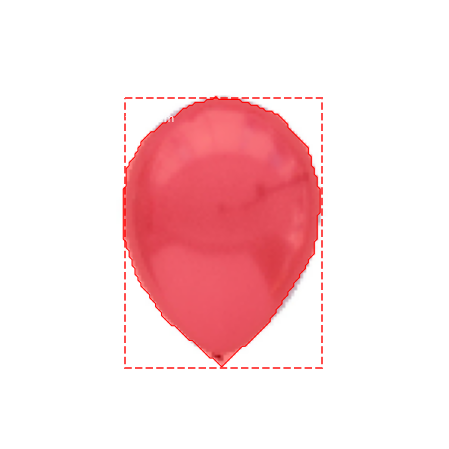

In [24]:
# visualize sample image
log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

In [25]:
def get_ax(rows=1, cols=1, size=8):
    """
    Return a Matplotlib Axes array to be used in all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax



In [26]:
def load_image(image_path):
  img = cv2.imread(image_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (inference_config.IMAGE_MIN_DIM, inference_config.IMAGE_MIN_DIM))
  return img

In [27]:
image_path = os.path.join(DATASET_PATH, 'val','test1.jpg')
img = load_image(image_path)

In [31]:
def infer_object(image):
  # making prediction
  results = model.detect([image], verbose=1)

  results = results[0]
  visualize.display_instances(image, results['rois'], results['masks'], results['class_ids'], 
                              dataset_val.class_names, results['scores'], ax=get_ax())
  return results

Processing 1 images
image                    shape: (128, 128, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  128.00000  int64
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32


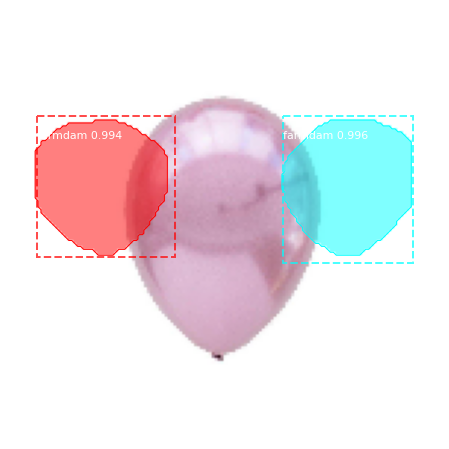

In [32]:
results = infer_object(img)